Example
====


In this example we use emupy to tackle a very simple toy problem. We have two underlying functions of $x$, $f$ and $g$, from which we make noisy data. The objective is to use emupy to set up a prediction function for the noisy data that accurately describes the underlying functions. 

This is one of the most barebones examples of how emupy is used, and highlights the usage and potential flaws of using pca. In the example, we have set up our $f$ and $g$ to be highly correlated, which is when pca is very successful. These functions can be changed, and pca will respond in effectiveness. Of course, in this example, the data set is small enough that turning pca off will result in no observable change in runtime. With larger data sets, however, pca can reduce runtime significantly.

In this example, turning pca on yields a setup and runtime of E.sphere, E.klt, and E.train of 0.35-0.75 seconds, while turning it off bumps up the run time to between 0.85-1.25 seconds. 

In [190]:
# Import modules
%matplotlib inline
import numpy as np
import emupy as emu
import sklearn.gaussian_process as gp
import scipy.stats as stats
import matplotlib.pyplot as plt
import time

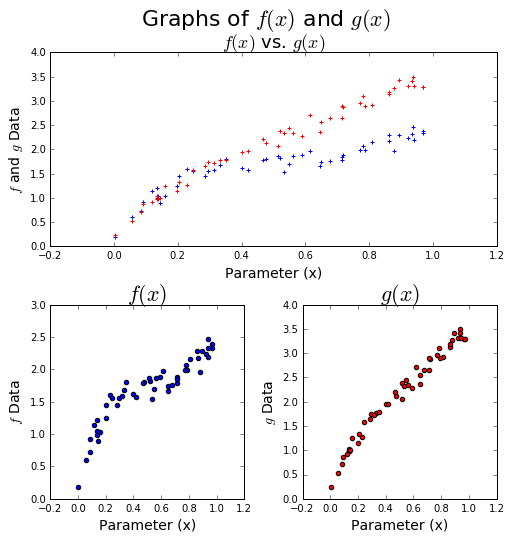

In [191]:
# Format of setting up data:
# Choose how many points between 0 and 1
n = 100

# Create linspace array
all_x = np.random.uniform(0,1,n)

# Specify functions
# defaults:  
# f(x) = sqrt(x)
# g(x) = 
f = lambda x: np.sqrt(6*x) + np.sin(x*np.pi*2)/4 + np.random.normal(0,.1,n)
g = lambda x: np.sqrt(6*x) + x +  np.random.normal(0,.1,n)

# Create data array
fx = f(all_x)
gx = g(all_x)
all_data = np.array([fx,gx]).T

# Choose half of it to train the gaussian, half of it for cross validation at the end
indices = np.arange(0,n,1)
rand = np.random.choice(indices,n//2,replace=False)
select = np.zeros(n,dtype='bool')
select[rand] = True

x_array = all_x[select]
data = all_data[select]
x_cv = all_x[~select]
data_cv = all_data[~select]

fx = data.T[0]
gx = data.T[1]

# Plot data against one another
fig1 = plt.figure(figsize=(8,8))
fig1.suptitle('Graphs of $f(x)$ and $g(x)$',fontsize=22)
fig1.subplots_adjust(wspace=0.3,hspace=0.3)

ax1 = fig1.add_subplot(211)
ax1.scatter(x_array,fx,marker='+')
ax1.scatter(x_array,gx,c='r',marker='+')
ax1.set_title('$f(x)$ vs. $g(x)$',fontsize='18')
ax1.set_xlabel('Parameter (x)',fontsize=14)
ax1.set_ylabel('$f$ and $g$ Data',fontsize=14)

# Plot only f(x)
ax2 = fig1.add_subplot(223)
ax2.scatter(x_array,fx)
ax2.set_title('$f(x)$',fontsize=22)
ax2.set_xlabel('Parameter (x)',fontsize=14)
ax2.set_ylabel('$f$ Data',fontsize=14)

# Plot only g(x)
axe3 = fig1.add_subplot(224)
axe3.scatter(x_array,gx,c='r')
axe3.set_title('$g(x)$',fontsize=22)
axe3.set_xlabel('Parameter (x)',fontsize=14)
axe3.set_ylabel('$g$ Data',fontsize=14)

In [192]:
E = emu.Emu()

# Specify number of samples in training data
E.N_samples = len(x_array)

# Specify number of model parameters
E.N_params = 1

# Specify number of data elements
E.N_data = 2

# Specify usage of pca or not (automatically sets N_modes too). Try toggling this and watching the fit
# change, but keep in mind the runtime changes too with larger data pools.
E.use_pca = True
if E.use_pca == True: E.N_modes = 1
else: E.N_modes = 2

# Choose regression model for interpolation functions
E.reg_meth = 'gaussian'

# Choose to log normalize the data before regression
E.lognorm = False

# Whiten the covariance matrix of the data before performing KLT
E.cov_whiten = False

In [193]:
# Set fidutial arrays. These are just arrays of the average (or median) of every input parameter and
# data element. Used for centering the data.
E.fid_grid = np.array([np.median(x_array.T)])
E.fid_data = np.array(map(lambda x: np.median(x),data.T))

In [194]:
# Since we have only have one input parameter, 'x', numpy won't allow transposing the array from a flat
# (,n) vector into a column vector (n,). The trick around this is to define x_data as a matrix of
# x_array, and transpose that into a column matrix. With any parameter space with more than one
# element, you can define x_data as a column array of all coordinates entries.
x_data = np.matrix(x_array).T

In [195]:
# Now that we have our data set up, we can initialize the timer
starttime = time.time()

## This cell is the general procedure of using emupy. Whereas the procedure is mostly invariant to the data,
## the kwargs are what is customizable. One can also specify exactly how the gaussian process regression will work
## with the gp_kwargs dictionary.
# Call E.sphere (cholesky decomposition) on the input column array 
E.sphere(x_data,fid_grid = E.fid_grid, save_chol=True)

# Call klt on the data array to find eigenvectors (used as pca bases)
E.klt(data,fid_data=E.fid_data,normalize=True)

## Setup Gaussian Process kwargs
# Setup a squared exponential kernel with diagonal noise hyperparameter
kernel = gp.kernels.RBF(length_scale=np.ones(E.N_params)) + gp.kernels.WhiteKernel(noise_level=1e-6)

# How many times to restart MLE search of hyperparameters
n_restarts_optimizer = 10

# Which optimizer to use
optimizer='fmin_l_bfgs_b'

# pack into a dictionary
gp_kwargs = {'kernel':kernel, 'n_restarts_optimizer':n_restarts_optimizer, 'optimizer':optimizer}
E.gp_kwargs = gp_kwargs

## Initialize E.train, which sets up gaussian processes for future predictions.
E.train(data,x_data)

# See how long it took!

runtime = time.time()-starttime
print runtime

0.371756076813


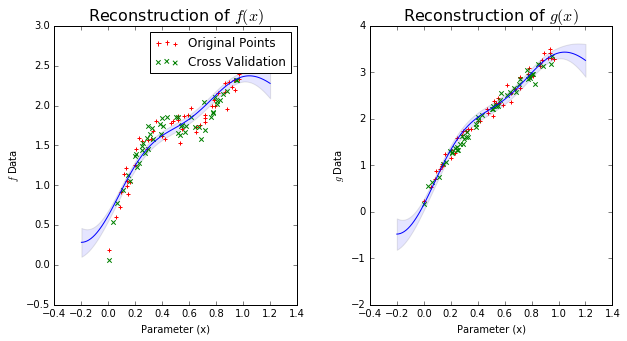

In [196]:
# Create new prediction coordinate array
nnew = 100
pred_coords = np.linspace(-0.2,1.2,nnew)
pred_input = np.asmatrix(pred_coords).T

# Run through E.predict
E.predict(pred_input)

# Extract predictions (E.recon) and predicted error (E.recon_err) and make graphable arrays
pred_output = E.recon
pred_err= E.recon_err
err_high = (pred_output+pred_err).T
err_low = (pred_output-pred_err).T

fig2 = plt.figure(figsize=(10,5))
fig2.subplots_adjust(wspace=0.3)

# Plot 1: prediction of f(x) against the original f(x) data (red) and cross validation (green)
ax3 = fig2.add_subplot(121)
ax3.plot(pred_coords,pred_output.T[0])
ax3.fill_between(pred_coords,err_low[0],err_high[0],alpha=0.1)
orig = ax3.scatter(x_array,fx,color='r',marker='+')
cv = ax3.scatter(x_cv,data_cv.T[0],color = 'g', marker='x')
ax3.set_title('Reconstruction of $f(x)$',fontsize=16)
ax3.set_xlabel('Parameter (x)')
ax3.set_ylabel('$f$ Data')

# Plot 2: prediction of g(x) against the original g(x) data (red) and cross validation data (green)
ax4 = fig2.add_subplot(122)
ax4.plot(pred_coords,pred_output.T[1])
ax4.scatter(x_array,gx,color = 'r', marker='+')
ax4.fill_between(pred_coords,err_low[1],err_high[1],alpha=0.1)
ax4.scatter(x_cv,data_cv.T[1],color = 'g', marker='x')
ax4.set_title('Reconstruction of $g(x)$', fontsize=16)
ax4.set_xlabel('Parameter (x)')
ax4.set_ylabel('$g$ Data')

ax3.legend([orig, cv], ["Original Points", "Cross Validation"])

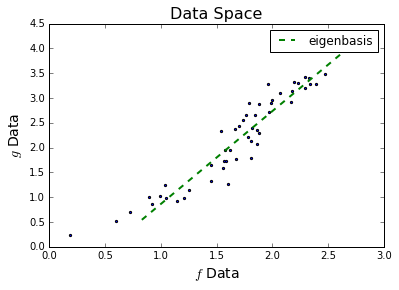

In [204]:
## Here we go back and look at the pca transform
# Inicialize plt
fig3= plt.figure()
ax5 = fig3.add_subplot(111)

# Plot f(x) and f(y) against one another
ax5.scatter(fx,gx,marker='.')

# Extract eigenvector values used as bases for pca
basis = E.eig_vecs[0]
basis = np.array([2*basis,-2*basis]) + E.fid_data
basis = basis.T

# Plot the basis vector along which pca is done on the plot!
eigplot, = ax5.plot(basis[0],basis[1],c='green',linestyle='--',lw=2)

ax5.set_title('Data Space',fontsize=16)
ax5.set_xlabel('$f$ Data',fontsize=14)
ax5.set_ylabel('$g$ Data',fontsize=14)
ax5.legend([eigplot],['eigenbasis'])

# If the scatter is highly correlated, pca works very well. If its very random and uncorrelated,
# pca fails to be an effective method of simplifying the data and the output is skewed.

In [198]:
# Now for some statistical cross validation. First, we will use cross_validate to generate
# predictions for g and f for every x value in x_cv. Remember that we have to turn the array x_cv
# into a matrix x_cvm in order to pass it through emupy.
x_cvm = np.asmatrix(x_cv).T
E.cross_validate(x_cvm,data_cv)

# First, the average-square of the CV data from the prediction
avsq = map(lambda x: np.sum(x)/len(x),
           (E.recon_cv - data_cv).T**2)
print "Avg-squared [f,g]: " + str(avsq)

# Next, the chi-square of each data element
chisq = map(lambda x: sum(x)/len(x),
            ((E.recon_cv - data_cv)**2/(E.recon_err_cv**2)).T)
print "Chi-squared [f,g]: " + str(chisq)

Avg-squared [f,g]: [0.02529007430591753, 0.016011612993654448]
Chi-squared [f,g]: [8.0902062588535113, 1.5618896717082169]
